In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from helper_functions import create_tensorboard_callback
from helper_functions import loop_through_files, evaluate_model_results, evaluate_text_preds

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Functions

In [3]:
def compile_model(model_):
    compiled_model = model_.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])
    return compiled_model

In [4]:
def fit_model(model_):
    fitted_model = model_.fit(train_dataset,                             
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=5,
                              validation_data=(valid_dataset),
                              validation_steps=int(0.1 * len(valid_dataset))
                            )
    return fitted_model

## Milestone Project 2 : SkimLit

From [PubMed 200k RCT Dataset](https://github.com/Franck-Dernoncourt/pubmed-rct)

### Data Preprocessing

In [5]:
data_dir = '../../../Datasets/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
loop_through_files(dataset_dir=data_dir)

['dev.txt', 'test.txt', 'train.txt']
There are 0 directories and 3 files in '../../../Datasets/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'.


In [7]:
#files = ['dev.txt', 'test.txt', 'train.txt']
#filenames = [i.split('.')[0] for i in files]

def get_lines(filename, data_dir=data_dir):
    #print(data_dir+filename)
    with open(data_dir+filename+'.txt', "r", encoding='utf-8-sig') as f:
        return f.readlines()

In [8]:
test_text = get_lines('test')
train_text = get_lines('train')

In [9]:
len(train_text)

210040

In [10]:
def preprocess_text_with_line_numbers(filenames):
    input_lines = get_lines(filenames) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] 
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() 
            
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
    
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
  
    return abstract_samples

### Disecting the function
# get all the lines from the file using the past function
# abstract gets saved with indices
# splits the nextlines from \n
# enumerate generates a line number / index number and its value
# then just store them to a dictionary


In [11]:
train_data = preprocess_text_with_line_numbers('train')
test_data = preprocess_text_with_line_numbers('test')
val_data = preprocess_text_with_line_numbers('dev')

In [12]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

In [13]:
train_df[:5]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [14]:
# get the number of categories 
len_cat = train_df.target.nunique()

In [15]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [16]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

In [17]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))

In [18]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))

C:\Users\gilgamesh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [20]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

### Text Vectorizer and Embeddings

In [21]:
max_vocab_length = 65000
max_length = 55

In [22]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_sequence_length=max_length,
)

In [23]:
text_vectorizer.adapt(train_sentences)

In [24]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [25]:
embedding = tf.keras.layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    input_length=max_length,
    embeddings_initializer='uniform'
)

## Building Models

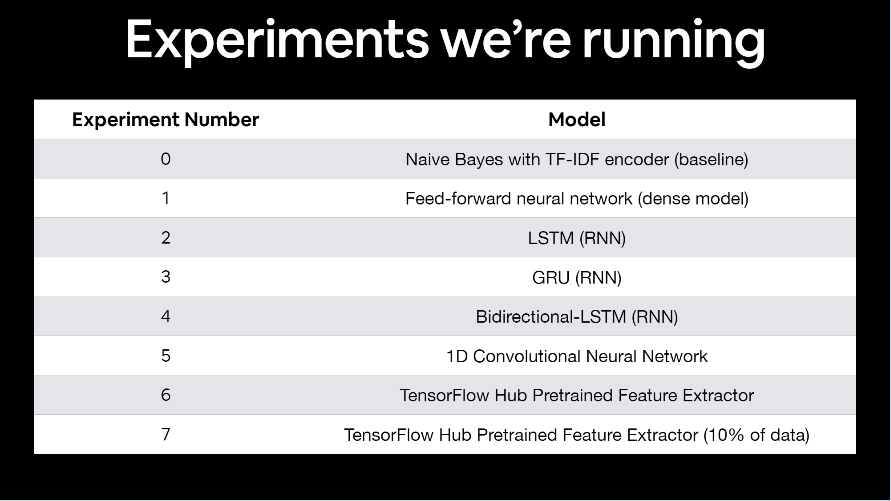

Image taken from [MDBourke's Slide for NLP](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/slides/08_natural_language_processing_in_tensorflow.pdf)

**Model 0**: Naive Bayes (Baseline)  
**Model 1**: Feed-forward neural network (Dense Model)  
**Model 2**: LSTM model (RNN)  
**Model 3**: GRU Model (RNN)  
**Model 4**: Bidirectional-LTSM Model (RNN)  
**Model 5**: 1D Convolutional Neural Network (CNN)  
**Model 6**: TensorFlow Hub Pretrained Feature Extration (Transfer Learning)  

### Model 0 - Naive Bayes (Baseline)

In [26]:
model_0 = Pipeline([
    ('tfidfVec', TfidfVectorizer()),
    ('clf', MultinomialNB())
],verbose=True)

model_0.fit(X=train_sentences, y=train_labels_encoded)

[Pipeline] .......... (step 1 of 2) Processing tfidfVec, total=   2.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


Pipeline(steps=[('tfidfVec', TfidfVectorizer()), ('clf', MultinomialNB())],
         verbose=True)

In [27]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [28]:
model_0_preds = model_0.predict(val_sentences)

In [29]:
model_0_results = evaluate_model_results(model_0_preds, val_labels_encoded)

In [30]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

### Model 1 - Feed-Forward Neural Network (Dense Model)

First we'll need to convert our data to tensors,
We'll also need to get the max 

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [32]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [33]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax')(x)


model_1 = tf.keras.models.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [34]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 8,300,293
Trainable params: 8,300,293
Non-train

In [35]:
model_1.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=5,
            validation_data=(valid_dataset),
            validation_steps=int(0.1 * len(valid_dataset))
           )

Epoch 1/5
562/562 [==============================] - 6s 8ms/step - loss: 1.2648 - accuracy: 0.5371 - val_loss: 0.9828 - val_accuracy: 0.6180
Epoch 2/5
562/562 [==============================] - 4s 7ms/step - loss: 0.8460 - accuracy: 0.6908 - val_loss: 0.7586 - val_accuracy: 0.7284
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.7147 - accuracy: 0.7422 - val_loss: 0.6770 - val_accuracy: 0.7540
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.6552 - accuracy: 0.7697 - val_loss: 0.6356 - val_accuracy: 0.7573
Epoch 5/5
562/562 [==============================] - 4s 7ms/step - loss: 0.6378 - accuracy: 0.7734 - val_loss: 0.6100 - val_accuracy: 0.7766


In [36]:
model_1_preds = model_1.predict(valid_dataset)
model_1_preds = tf.squeeze(tf.round(model_1_preds))

In [37]:
model_1_results = evaluate_model_results(model_1_preds, val_labels_one_hot)

In [38]:
model_1_results

{'accuracy': 0.6940619621342513,
 'precision': 0.8308201149180294,
 'recall': 0.6940619621342513,
 'f1-score': 0.7467901239804853}

### Model 2 - LSTM Model (RNN)

In [39]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
#x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x)
#x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.models.Model(inputs, outputs)

compile_model(model_2)

fit_model(model_2)

Epoch 1/5
562/562 [==============================] - 9s 11ms/step - loss: 0.9952 - accuracy: 0.5925 - val_loss: 0.9214 - val_accuracy: 0.6536
Epoch 2/5
562/562 [==============================] - 5s 10ms/step - loss: 1.0021 - accuracy: 0.6149 - val_loss: 1.1832 - val_accuracy: 0.5472
Epoch 3/5
562/562 [==============================] - 5s 10ms/step - loss: 1.1605 - accuracy: 0.5555 - val_loss: 1.1364 - val_accuracy: 0.5625
Epoch 4/5
562/562 [==============================] - 5s 10ms/step - loss: 1.0239 - accuracy: 0.5941 - val_loss: 0.8996 - val_accuracy: 0.6533
Epoch 5/5
562/562 [==============================] - 5s 10ms/step - loss: 0.7847 - accuracy: 0.6854 - val_loss: 0.7646 - val_accuracy: 0.6941


In [40]:
model_2_preds = model_2.predict(valid_dataset)
model_2_preds = tf.squeeze(tf.round(model_2_preds))

In [41]:
model_2_results = evaluate_model_results(model_2_preds, val_labels_one_hot)

C:\Users\gilgamesh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
model_2_results

{'accuracy': 0.5679531312061432,
 'precision': 0.6515933161542197,
 'recall': 0.5679531312061432,
 'f1-score': 0.5981430750409373}

### Model 3 - GRU Model (RNN)

In [43]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(64)(x)
#x = tf.keras.layers.Dense(64)(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax', name='output_layer')(x)

model_3 = tf.keras.models.Model(inputs, outputs)

In [44]:
compile_model(model_3)
fit_model(model_3)

Epoch 1/5
562/562 [==============================] - 7s 10ms/step - loss: 1.0528 - accuracy: 0.5412 - val_loss: 0.7480 - val_accuracy: 0.6835
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.7645 - accuracy: 0.6934 - val_loss: 0.7271 - val_accuracy: 0.7011
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6772 - accuracy: 0.7439 - val_loss: 0.6543 - val_accuracy: 0.7357
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6233 - accuracy: 0.7656 - val_loss: 0.6264 - val_accuracy: 0.7606
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5658 - accuracy: 0.7918 - val_loss: 0.5863 - val_accuracy: 0.7846


In [45]:
model_3_preds = model_3.predict(valid_dataset)
model_3_preds = tf.squeeze(tf.round(model_3_preds))

In [46]:
model_3_results = evaluate_model_results(model_3_preds, val_labels_one_hot)

In [47]:
model_3_results

{'accuracy': 0.7461273666092944,
 'precision': 0.8078011041080839,
 'recall': 0.7461273666092944,
 'f1-score': 0.7671924688433378}

### Model 4 - Bidirectional LSTM (RNN)

In [48]:
from tensorflow.keras.layers import LSTM

In [134]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(LSTM(64))(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax', name='output_layer')(x)

model_4 = tf.keras.models.Model(inputs, outputs)

compile_model(model_4)
fit_model(model_4)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 5) and (None, 128) are incompatible


In [50]:
model_4_preds = model_4.predict(valid_dataset)
model_4_preds = tf.squeeze(tf.round(model_4_preds))

In [51]:
model_4_results = evaluate_model_results(model_4_preds, val_labels_one_hot)

In [52]:
model_4_results

{'accuracy': 0.7876671521249835,
 'precision': 0.8284503297371726,
 'recall': 0.7876671521249835,
 'f1-score': 0.8039901116907967}

### Model 5 - 1D Convolutional Neural Network (CNN)

In [53]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', strides=1, padding='valid')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax')(x)

model_5 = tf.keras.models.Model(inputs, outputs)

compile_model(model_5)
model_5.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=5,
            validation_data=(valid_dataset),
            validation_steps=int(0.1 * len(valid_dataset))
           )

Epoch 1/5
562/562 [==============================] - 7s 8ms/step - loss: 0.5764 - accuracy: 0.7931 - val_loss: 0.5701 - val_accuracy: 0.7912
Epoch 2/5
562/562 [==============================] - 4s 8ms/step - loss: 0.5033 - accuracy: 0.8217 - val_loss: 0.5639 - val_accuracy: 0.7929
Epoch 3/5
562/562 [==============================] - 4s 8ms/step - loss: 0.4729 - accuracy: 0.8341 - val_loss: 0.5759 - val_accuracy: 0.7749
Epoch 4/5
562/562 [==============================] - 4s 8ms/step - loss: 0.4470 - accuracy: 0.8450 - val_loss: 0.5468 - val_accuracy: 0.8009
Epoch 5/5
562/562 [==============================] - 4s 8ms/step - loss: 0.4370 - accuracy: 0.8506 - val_loss: 0.5422 - val_accuracy: 0.8025


In [54]:
model_5_preds = model_5.predict(valid_dataset)
model_5_preds = tf.squeeze(tf.round(model_5_preds))

In [55]:
model_5_results = evaluate_model_results(model_5_preds, val_labels_one_hot)

In [56]:
model_5_results

{'accuracy': 0.7747914735866543,
 'precision': 0.8243516858705823,
 'recall': 0.7747914735866543,
 'f1-score': 0.7967963947219356}

### Model 6 - Transfer Learning USE

In [57]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=False,
                                       name='USE')

In [58]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = sentence_encoder_layer(inputs)
x = tf.keras.layers.Dense(128,activation="relu")(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax')(x)

model_6 = tf.keras.Model(inputs, outputs)

In [59]:
compile_model(model_6)

In [60]:
model_6.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=5,
            validation_data=(valid_dataset),
            validation_steps=int(0.1 * len(valid_dataset))
           )

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9191 - accuracy: 0.6486 - val_loss: 0.7990 - val_accuracy: 0.6922
Epoch 2/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7701 - accuracy: 0.7002 - val_loss: 0.7569 - val_accuracy: 0.7064
Epoch 3/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7542 - accuracy: 0.7107 - val_loss: 0.7400 - val_accuracy: 0.7141
Epoch 4/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7194 - accuracy: 0.7244 - val_loss: 0.7114 - val_accuracy: 0.7281
Epoch 5/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7269 - accuracy: 0.7199 - val_loss: 0.6910 - val_accuracy: 0.7357


In [61]:
model_6_preds = model_6.predict(valid_dataset)
model_6_preds = tf.squeeze(tf.round(model_6_preds))

In [62]:
model_6_results = evaluate_model_results(model_6_preds, val_labels_one_hot)

In [63]:
model_6_results

{'accuracy': 0.6582152786972064,
 'precision': 0.7886941022401219,
 'recall': 0.6582152786972064,
 'f1-score': 0.7048638827741521}

### Model 7 Feature Extraction and Fine Tuning

In [64]:
from helper_functions import create_checkpoint_callback, create_early_stopping_callback, create_reduce_lr_callback, create_tensorboard_callback

In [65]:
checkpoint_path = './NLP-NLU-Files/checkpoints/'

In [66]:
earlystopping_callback = create_early_stopping_callback(
    metric='val_accuracy',
    patience=3
)

checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_loss',
    save_best=True,
    save_weights=True,
)

lr_callback = create_reduce_lr_callback(
    metric="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

In [67]:
model_6.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=100,
            validation_data=(valid_dataset),
            validation_steps=int(0.1 * len(valid_dataset)),
            callbacks=[checkpoint_callback, 
                       lr_callback,
                       earlystopping_callback])

Epoch 1/100
559/562 [============================>.] - ETA: 0s - loss: 0.6993 - accuracy: 0.7336
Epoch 00001: val_loss improved from inf to 0.68189, saving model to ./NLP-NLU-Files/checkpoints\
562/562 [==============================] - 20s 36ms/step - loss: 0.6995 - accuracy: 0.7336 - val_loss: 0.6819 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 2/100
559/562 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.7402
Epoch 00002: val_loss improved from 0.68189 to 0.67406, saving model to ./NLP-NLU-Files/checkpoints\
562/562 [==============================] - 20s 36ms/step - loss: 0.6759 - accuracy: 0.7405 - val_loss: 0.6741 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 3/100
560/562 [============================>.] - ETA: 0s - loss: 0.6709 - accuracy: 0.7423
Epoch 00003: val_loss improved from 0.67406 to 0.67278, saving model to ./NLP-NLU-Files/checkpoints\
562/562 [==============================] - 20s 35ms/step - loss: 0.6707 - accuracy: 0.7424 - val_loss: 0.6728 - val_ac


Epoch 00011: val_loss did not improve from 0.62470
562/562 [==============================] - 2s 4ms/step - loss: 0.6794 - accuracy: 0.7650 - val_loss: 0.6275 - val_accuracy: 0.7666 - lr: 1.0000e-04


In [68]:
model_7_preds = model_6.predict(valid_dataset)
model_7_preds = tf.squeeze(tf.round(model_6_preds))

In [69]:
model_7_results = evaluate_model_results(model_6_preds, val_labels_one_hot)
model_7_results

{'accuracy': 0.6582152786972064,
 'precision': 0.7886941022401219,
 'recall': 0.6582152786972064,
 'f1-score': 0.7048638827741521}

### Comparing Model Results

In [70]:
all_model_results = pd.DataFrame({
    '0_baseline' : model_0_results,
    '1_dense_layer' : model_1_results,
    '2_LSTM' : model_2_results,
    '3_GRU' : model_3_results,
    '4_bidirectional' : model_4_results,
    '5_conv1d' : model_5_results,
    '6_tf_hub_use_encoder' : model_6_results,
    '7_tf_fine_tuning' : model_7_results,
})
all_model_results.T

,accuracy,precision,recall,f1-score
0_baseline,0.721832,0.718647,0.721832,0.698925
1_dense_layer,0.694062,0.830820,0.694062,0.746790
2_LSTM,0.567953,0.651593,0.567953,0.598143
3_GRU,0.746127,0.807801,0.746127,0.767192
4_bidirectional,0.787667,0.828450,0.787667,0.803990
5_conv1d,0.774791,0.824352,0.774791,0.796796
6_tf_hub_use_encoder,0.658215,0.788694,0.658215,0.704864
7_tf_fine_tuning,0.658215,0.788694,0.658215,0.704864


## Building a Character level Tokenizer and Embedding

In [71]:
def split_characters(text):
    return ' '.join(list(text))

In [72]:
train_sentence_char = [split_characters(sentence) for sentence in train_sentences]
test_sentence_char = [split_characters(sentence) for sentence in test_sentences]
val_sentence_char = [split_characters(sentence) for sentence in val_sentences]

In [73]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len
output_sequence_length = int(np.percentile(char_lens, 95))

In [74]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
    name='CHAR_VECTORIZER'
)

char_vectorizer.adapt(train_sentence_char)

In [76]:
char_embed = tf.keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                       output_dim=25,
                                       mask_zero=False,
                                       name='CHAR_EMBEDDER')

In [77]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_sentence_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_sentence_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Building Models for Characterized Dataset

### Model 8 - Feed-Forward Neural Network (Dense Model)

In [78]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_shape')
vectorize = char_vectorizer(inputs)
embed = char_embed(vectorize)
x = tf.keras.layers.GlobalAveragePooling1D()(embed)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax')(x)

model_8 = tf.keras.Model(inputs, outputs)

model_8.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_8.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=5,
            validation_data=val_char_dataset,
            validation_steps=int(0.1 *len(val_char_dataset))
           )

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.4832 - accuracy: 0.3346 - val_loss: 1.4596 - val_accuracy: 0.3298
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.4484 - accuracy: 0.3773 - val_loss: 1.4447 - val_accuracy: 0.4019
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 1.4361 - accuracy: 0.3981 - val_loss: 1.4277 - val_accuracy: 0.4156
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 1.4105 - accuracy: 0.4212 - val_loss: 1.4073 - val_accuracy: 0.4195
Epoch 5/5
562/562 [==============================] - 3s 4ms/step - loss: 1.3932 - accuracy: 0.4188 - val_loss: 1.3851 - val_accuracy: 0.4315


In [114]:
model_8_pred_probs = model_8.predict(val_char_dataset )

In [115]:
model_8_preds = tf.argmax(model_8_pred_probs, axis=1)
model_8_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 2, 2, 2], dtype=int64)>

In [116]:
model_8_results = evaluate_model_results(model_8_preds, val_labels_encoded)
model_8_results

{'accuracy': 0.33350986363034557,
 'precision': 0.31966099801787373,
 'recall': 0.33350986363034557,
 'f1-score': 0.1851073724218701}

### Model 9 - LSTM Model

In [79]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
vectorize = char_vectorizer(inputs)
embed = char_embed(vectorize)
#x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(embed)
#x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax', name='output_layer')(x)

model_9 = tf.keras.models.Model(inputs, outputs)

model_9.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_9.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=5,
            validation_data=val_char_dataset,
            validation_steps=int(0.1 *len(val_char_dataset))
           )

Epoch 1/5
562/562 [==============================] - 9s 14ms/step - loss: 1.4800 - accuracy: 0.3273 - val_loss: 1.4740 - val_accuracy: 0.3298
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 1.4689 - accuracy: 0.3334 - val_loss: 1.4726 - val_accuracy: 0.3298
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 1.4712 - accuracy: 0.3313 - val_loss: 1.4734 - val_accuracy: 0.3225
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 1.4647 - accuracy: 0.3307 - val_loss: 1.4739 - val_accuracy: 0.3298
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 1.4678 - accuracy: 0.3320 - val_loss: 1.4741 - val_accuracy: 0.3298


In [117]:
model_9_pred_probs = model_9.predict(val_char_dataset )

In [118]:
model_9_preds = tf.argmax(model_9_pred_probs, axis=1)
model_9_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 4, 4, ..., 4, 4, 4], dtype=int64)>

In [119]:
model_9_results = evaluate_model_results(model_9_preds, val_labels_encoded)
model_9_results

C:\Users\gilgamesh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.32854494902687675,
 'precision': 0.3042067174663866,
 'recall': 0.32854494902687675,
 'f1-score': 0.17230073354061556}

### Model 10 - Bidrectional LSTM

In [80]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
vectorize = char_vectorizer(inputs)
embed = char_embed(vectorize)
x = tf.keras.layers.Bidirectional(LSTM(128))(embed)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax', name='output_layer')(x)

model_10 = tf.keras.models.Model(inputs, outputs)

model_10.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_10.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=10,
            validation_data=val_char_dataset,
            validation_steps=int(0.1 *len(val_char_dataset))
           )

Epoch 1/10
562/562 [==============================] - 24s 38ms/step - loss: 1.3743 - accuracy: 0.4076 - val_loss: 1.2976 - val_accuracy: 0.4342
Epoch 2/10
562/562 [==============================] - 21s 37ms/step - loss: 1.3112 - accuracy: 0.4348 - val_loss: 1.2429 - val_accuracy: 0.4777
Epoch 3/10
562/562 [==============================] - 20s 36ms/step - loss: 1.2120 - accuracy: 0.4953 - val_loss: 1.1731 - val_accuracy: 0.5146
Epoch 4/10
562/562 [==============================] - 20s 36ms/step - loss: 1.1200 - accuracy: 0.5442 - val_loss: 1.0927 - val_accuracy: 0.5509
Epoch 5/10
562/562 [==============================] - 21s 38ms/step - loss: 1.0511 - accuracy: 0.5707 - val_loss: 0.9891 - val_accuracy: 0.6037
Epoch 6/10
562/562 [==============================] - 22s 40ms/step - loss: 0.9837 - accuracy: 0.6097 - val_loss: 0.9247 - val_accuracy: 0.6360
Epoch 7/10
562/562 [==============================] - 21s 37ms/step - loss: 0.9366 - accuracy: 0.6282 - val_loss: 0.8942 - val_accuracy:

In [81]:
model_10.evaluate(val_char_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.8043 - accuracy: 0.6889


[0.8043478727340698, 0.6889315247535706]

In [83]:
model_10_pred_probs = model_10.predict(val_char_dataset )

In [84]:
model_10_preds = tf.argmax(model_10_pred_probs, axis=1)
model_10_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1], dtype=int64)>

In [87]:
model_10_results = evaluate_model_results(model_10_preds, val_labels_encoded)
model_10_results

{'accuracy': 0.6889315503773336,
 'precision': 0.6893057135355648,
 'recall': 0.6889315503773336,
 'f1-score': 0.6809442848090302}

### Model 11 - GRU Model

In [88]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
vectorize = char_vectorizer(inputs)
embed = char_embed(vectorize)
x = tf.keras.layers.GRU(64)(embed)
#x = tf.keras.layers.Dense(64)(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax', name='output_layer')(x)

model_11 = tf.keras.models.Model(inputs, outputs)

model_11.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_11.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=5,
            validation_data=val_char_dataset,
            validation_steps=int(0.1 *len(val_char_dataset))
           )

Epoch 1/5
562/562 [==============================] - 9s 13ms/step - loss: 1.4801 - accuracy: 0.3248 - val_loss: 1.4739 - val_accuracy: 0.3291
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 1.4691 - accuracy: 0.3321 - val_loss: 1.4724 - val_accuracy: 0.3298
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 1.4712 - accuracy: 0.3315 - val_loss: 1.4740 - val_accuracy: 0.3225
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 1.4648 - accuracy: 0.3309 - val_loss: 1.4747 - val_accuracy: 0.3295
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 1.4679 - accuracy: 0.3308 - val_loss: 1.4744 - val_accuracy: 0.3298


In [89]:
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
vectorize = char_vectorizer(inputs)
embed = char_embed(vectorize)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embed)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(len_cat, activation="softmax")(x)

model_11 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

model_11.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [90]:
model_11.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=5,
            validation_data=val_char_dataset,
            validation_steps=int(0.1 *len(val_char_dataset))
           )

Epoch 1/5
562/562 [==============================] - 3s 5ms/step - loss: 1.1935 - accuracy: 0.5130 - val_loss: 1.0622 - val_accuracy: 0.5725
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.0543 - accuracy: 0.5765 - val_loss: 0.9818 - val_accuracy: 0.6167
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9910 - accuracy: 0.6093 - val_loss: 0.9492 - val_accuracy: 0.6370
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9393 - accuracy: 0.6274 - val_loss: 0.9059 - val_accuracy: 0.6403
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9222 - accuracy: 0.6368 - val_loss: 0.8742 - val_accuracy: 0.6725


In [91]:
model_11.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8972 - accuracy: 0.6528


[0.89720618724823, 0.6527869701385498]

In [94]:
model_11_preds = model_11.predict(val_char_dataset)
model_11_preds = tf.argmax(model_11_preds, axis=1)

In [95]:
model_11_results = evaluate_model_results(model_11_preds, val_labels_encoded)
model_11_results

{'accuracy': 0.6527869720640805,
 'precision': 0.6617196957454312,
 'recall': 0.6527869720640805,
 'f1-score': 0.6528314782832495}

### Model 12 - 1D Conv. Neural Network

In [126]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
vectorize = char_vectorizer(inputs)
embed = char_embed(vectorize)
x = tf.keras.layers.Conv1D(32, 5, activation='relu', strides=1, padding='valid')(embed)
#x = tf.keras.layers.Conv1D(32, 5, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(len_cat, activation='softmax')(x)

model_12 = tf.keras.models.Model(inputs, outputs)

model_12.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [127]:
model_12.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=5,
            validation_data=(valid_dataset),
            validation_steps=int(0.1 * len(valid_dataset))
           )

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2398 - accuracy: 0.5042 - val_loss: 1.5491 - val_accuracy: 0.3049
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.0521 - accuracy: 0.5816 - val_loss: 1.5905 - val_accuracy: 0.3138
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9856 - accuracy: 0.6160 - val_loss: 1.6152 - val_accuracy: 0.3168
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9358 - accuracy: 0.6368 - val_loss: 1.6236 - val_accuracy: 0.3152
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9228 - accuracy: 0.6394 - val_loss: 1.6085 - val_accuracy: 0.2394


### Comparing Model Results

In [125]:
all_model_results = pd.DataFrame({
    '8_baseline' : model_8_results,
    '9_dense_layer' : model_9_results,
    '10_LSTM' : model_10_results,
    '11_GRU' : model_11_results,
    '12_bidirectional' : model_11_results,
})
all_model_results.T

,accuracy,precision,recall,f1-score
8_baseline,0.333510,0.319661,0.333510,0.185107
9_dense_layer,0.328545,0.304207,0.328545,0.172301
10_LSTM,0.688932,0.689306,0.688932,0.680944
11_GRU,0.652787,0.661720,0.652787,0.652831
12_bidirectional,0.652787,0.661720,0.652787,0.652831


## Building a Combination of Text and Character

### Hybrid Model

In [179]:
### Building a Text model with the best resulting model
# Bidirectional LSTM
token_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='token_input')
token_vectorizer = text_vectorizer(token_inputs)
token_embedding = embedding(token_vectorizer)
token_bi_lstm = tf.keras.layers.Bidirectional(LSTM(64))(token_embedding)
token_outputs = tf.keras.layers.Dense(128, activation='softmax', name='output_layer')(token_bi_lstm)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [180]:
### Building a Char model with the best resulting model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectorize = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorize)
char_lstm = tf.keras.layers.LSTM(64)(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_lstm)

In [181]:
### Concatenate the layers

token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

In [182]:
### Creating the output layer
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(100, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(len_cat, activation='softmax')(final_dropout)

In [183]:
### Constructing the model
model_hybrid = tf.keras.Model(inputs=[token_model.input, char_model.input],
                              outputs=output_layer,
                              name='hybrid_layer')

In [174]:
#model_hybrid.summary()

In [175]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_sentence_char))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_sentence_char))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [176]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [184]:
model_hybrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"]
                    )

In [185]:
model_hybrid_history = model_hybrid.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 18s 25ms/step - loss: 0.9604 - accuracy: 0.6148 - val_loss: 0.7729 - val_accuracy: 0.6905
Epoch 2/10
562/562 [==============================] - 13s 24ms/step - loss: 0.5895 - accuracy: 0.7877 - val_loss: 0.6474 - val_accuracy: 0.7580
Epoch 3/10
562/562 [==============================] - 13s 24ms/step - loss: 0.4519 - accuracy: 0.8358 - val_loss: 0.6928 - val_accuracy: 0.7630
Epoch 4/10
562/562 [==============================] - 13s 24ms/step - loss: 0.4356 - accuracy: 0.8520 - val_loss: 0.6416 - val_accuracy: 0.7892
Epoch 5/10
562/562 [==============================] - 13s 24ms/step - loss: 0.4287 - accuracy: 0.8628 - val_loss: 0.6244 - val_accuracy: 0.7856
Epoch 6/10
562/562 [==============================] - 13s 24ms/step - loss: 0.6293 - accuracy: 0.7827 - val_loss: 0.5207 - val_accuracy: 0.8072
Epoch 7/10
562/562 [==============================] - 13s 24ms/step - loss: 0.5781 - accuracy: 0.8001 - val_loss: 0.5064 - val_accuracy:

In [186]:
model_hybrid.evaluate(val_char_token_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.4816 - accuracy: 0.8237


[0.4815712571144104, 0.8237124085426331]

In [187]:

model_hybrid_pred_probs = model_hybrid.predict(val_char_token_dataset)
model_hybrid_pred_probs

array([[5.81847668e-01, 1.51477873e-01, 2.95490623e-02, 2.14645311e-01,
        2.24801153e-02],
       [5.81245780e-01, 2.73579985e-01, 1.37923686e-02, 1.20080926e-01,
        1.13009317e-02],
       [3.37274432e-01, 9.81090218e-03, 1.40634635e-02, 6.36398315e-01,
        2.45282962e-03],
       ...,
       [2.83326190e-05, 2.01096991e-03, 3.33760912e-03, 1.21855219e-05,
        9.94610906e-01],
       [1.76836811e-02, 5.32149732e-01, 8.77594948e-03, 6.54548453e-03,
        4.34845179e-01],
       [1.96730755e-02, 9.53608632e-01, 1.17188913e-03, 4.19981871e-03,
        2.13466696e-02]], dtype=float32)

In [188]:
model_hybrid_preds = tf.argmax(model_hybrid_pred_probs, axis=1)
model_hybrid_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [189]:
model_hybrid_results = evaluate_model_results(y_true=val_labels_encoded,
                                    y_preds=model_hybrid_preds)
model_hybrid_results

{'accuracy': 0.8237124321461671,
 'precision': 0.8249175906435839,
 'recall': 0.8237124321461671,
 'f1-score': 0.8213170069534478}

In [191]:
model_hybrid.save('./NLP-NLU-Files/hybrid_model_best_performance')

INFO:tensorflow:Assets written to: ./NLP-NLU-Files/hybrid_model_best_performance\assets


INFO:tensorflow:Assets written to: ./NLP-NLU-Files/hybrid_model_best_performance\assets


In [193]:
loaded_model_hybrid = tf.keras.models.load_model('./NLP-NLU-Files/hybrid_model_best_performance')

In [194]:
loaded_model_hybrid.evaluate(val_char_token_dataset)

945/945 [==============================] - 220s 232ms/step - loss: 0.5034 - accuracy: 0.8198


[0.5033844709396362, 0.8197736144065857]

### Hybrid Model Fine-Tuning SQUEEZING MORE

In [195]:
earlystopping_callback = create_early_stopping_callback(
    metric='val_accuracy',
    patience=3
)

checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_loss',
    save_best=True,
    save_weights=True,
)

lr_callback = create_reduce_lr_callback(
    metric="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

In [213]:
model_hybrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=["accuracy"]
                    )

In [214]:
model_hybrid_history_fine_tuned = model_hybrid.fit(
    train_char_token_dataset, # train on dataset of token and characters
    steps_per_epoch=int(0.25 * len(train_char_token_dataset)),
    epochs=100,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.25 * len(val_char_token_dataset)),
    callbacks=[lr_callback, checkpoint_callback, earlystopping_callback]
)

Epoch 1/100
1404/1406 [============================>.] - ETA: 0s - loss: 0.3514 - accuracy: 0.8846
Epoch 00001: val_loss improved from inf to 0.51396, saving model to ./NLP-NLU-Files/checkpoints\
1406/1406 [==============================] - 40s 26ms/step - loss: 0.3516 - accuracy: 0.8846 - val_loss: 0.5140 - val_accuracy: 0.8238 - lr: 1.0000e-04
Epoch 2/100
1404/1406 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.9077
Epoch 00002: val_loss did not improve from 0.51396
1406/1406 [==============================] - 33s 24ms/step - loss: 0.2995 - accuracy: 0.9077 - val_loss: 0.5316 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 3/100
1404/1406 [============================>.] - ETA: 0s - loss: 0.4538 - accuracy: 0.8464
Epoch 00003: val_loss improved from 0.51396 to 0.48114, saving model to ./NLP-NLU-Files/checkpoints\
1406/1406 [==============================] - 35s 25ms/step - loss: 0.4536 - accuracy: 0.8464 - val_loss: 0.4811 - val_accuracy: 0.8236 - lr: 1.0000e-0


Epoch 00005: val_loss improved from 0.48018 to 0.48002, saving model to ./NLP-NLU-Files/checkpoints\
1406/1406 [==============================] - 4s 3ms/step - loss: 0.6018 - accuracy: 0.8333 - val_loss: 0.4800 - val_accuracy: 0.8261 - lr: 1.0000e-04


In [ ]:
hybrid_model.eva

## Questions

* why softmax explain softmax
* why do we do we use 95 percentile 
* why is text not strong to use
* why did we generate a sliced dataset
* why can't i set USE to trainable
* why do we use alphabet
* why lstm isnt working on character embedding
* why do we not have len_cat on hybrid layer fort token
* why do we build a diff dataset for both train sentence, and train chars
* what does tensorslices do

## TODO

* credit mrdbourke
* explain the project details on what we're doing/building
* links
* Set names of models
* describe the models
* print out the results for each model
* learn about dropout layers
* read what he did in his model 4
* after diving in read through the whole documentation

## Challenge

* Visualize them from embedding to model results